# TicTacToe Game

We first set up a game which can be used for human versus human play. Then, we explain the Monte Carlo Tree Search (MCTS) algorithm and use it for human versus machine and machin vs machine plays.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange

In [ ]:
players={1: "x", -1: "o", 0: "."}

def print_state(state):
    print("\n\t", end="")
    print("\n\t".join("  ".join([players[col] for col in row]) for row in state))
    print()     

## TicTacToe Game Setup
In this setup, we play on both sides, i.e., we decide what to play as players take turn. The algorithm calculates when a player wins or there's no move to make (draw) and terminates the game.

In [473]:
class TicTacToe(object):
    def __init__(self):
        self.board_size = 3
        self.first_player = 1

    def init_state(self):
        return np.zeros((self.board_size, self.board_size), dtype=np.int8)

    def next_state(self, state, action, player):
        row, col = self.coord(action)
        state[row, col] = player
        return state

    def coord(self, action):
        return action//self.board_size, action%self.board_size
    
    def opponent(self, player):
        return -player

    def won(self, state, action):
        row, col = self.coord(action)
        player = state[row, col]

        win_sum = player * self.board_size
        row_win = np.sum(state[row, :]) == win_sum
        col_win = np.sum(state[:, col]) == win_sum
        diag_win = np.sum(np.diag(state)) == win_sum
        offdiag_win = np.sum(np.diag(np.fliplr(state))) == win_sum
    
        return row_win or col_win or diag_win or offdiag_win
        
    def available_actions(self, state):
        return np.where(state.reshape(-1) == 0)[0]

    def is_over(self, state, action):
        '''
        The game is over when the player wins or there is no mover left.
        '''
        return self.won(state, action) or (np.sum(state == 0) == 0)

    def reward(self, won):
        return 1 if won else 0


### Human-Human Play

In [ ]:
t3 = TicTacToe()
state = t3.init_state()
player = t3.first_player

while True:
    print(f"player '{players[player]}' to play...")
    print_state(state)

    available_actions = t3.available_actions(state)
    print(f"available_actions: {available_actions}")
    
    if len(available_actions) == 0:
        print("draw!")
        break        

    action = input(f"provide a valid move: ")
    action = int(action)
    state = t3.next_state(state, action, player)

    if t3.won(state, action):
        print_state(state)
        print(f"player {players[player]} won!")
        break
    
    player = t3.opponent(player)


player 'x' to play...

	.  .  .
	.  .  .
	.  .  .

available_actions: [0 1 2 3 4 5 6 7 8]
player 'o' to play...

	.  .  .
	.  x  .
	.  .  .

available_actions: [0 1 2 3 5 6 7 8]
player 'x' to play...

	o  .  .
	.  x  .
	.  .  .

available_actions: [1 2 3 5 6 7 8]
player 'o' to play...

	o  x  .
	.  x  .
	.  .  .

available_actions: [2 3 5 6 7 8]
player 'x' to play...

	o  x  .
	.  x  .
	.  o  .

available_actions: [2 3 5 6 8]
player 'o' to play...

	o  x  .
	.  x  .
	x  o  .

available_actions: [2 3 5 8]
player 'x' to play...

	o  x  o
	.  x  .
	x  o  .

available_actions: [3 5 8]
player 'o' to play...

	o  x  o
	.  x  x
	x  o  .

available_actions: [3 8]
player 'x' to play...

	o  x  o
	o  x  x
	x  o  .

available_actions: [8]
player 'o' to play...

	o  x  o
	o  x  x
	x  o  x

available_actions: []
draw!


# Monte Carlo Tree Search

In this setion, we design a machine that can play against human or against another machine. We use Monte Carlo Tree Search (MCTS) to decide on the next move.

For a machine to be able to play against itself, we design it in a way that is agnostic of the player. We can assume that the player is always player 1, and change the perspective so that the machine act as player 2. For calrification, consider the following state in a $3\times 3$ TicTacToe game:

$$
S = 
\begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & -1 \\
0 & 0 & 0
\end{pmatrix}
$$

Player -1 is to play. We can see this is equvalent to player 1 in state $-S$, where all elements are multiplied by $-1$. Thus, we can design MCTS algorithm which is player agnostic.

The MCTS algorithms is composed of four stages as follows:

1. Selection
2. Expansion
3. Simulation
4. Backpropagation

The input to the MCTS algorithm is the current state and the output is a probability distribution of all the possible moves. Based on the distribution, we can decide which action to take. This can be just the move with the highest probability.

<center>
<img src="./images/mcts.png" width="400">
</center>

From the output of the MCTS algorithm, we choose the next action as $(0, 1)$, which prevents the opponent from winning, as detected by the algorithm.

The serarch tree is created as follows. We first create a root node with a given state. Then, we follow these steps:

1. Check if the current node is fully expanded or not. A node is fully expanded if it has children and no action can be taken.
2. If the node is fully expanded, we compute the Upper Confidence Bound (UCB) for each of its children and select the one with the highest UCB.
3. Continue the process until you reach a node which is not fully expanded.
4. Expand the node and move to the expanded node.
5. Run a simulation from the current node to determine if the player is won. Return the reward.
6. Run backpropagation to update the reward_sum and visit_count on all the nodes in the path from the node to the root.

This process is repeated for a set number of iteration. After that we look at the immediate children of the root node and compute the probability distribution of the visit_counts. We use this distribution to determine the next move.

<center>
<img src="./images/mcts-algorithm.png" width="500">
</center>

We use the following formula to compute the UCB of children nodes from a parent node to find out which child to select in the selection step.

$$
\frac{v_c}{n_c}+c\sqrt{\frac{\ln n_p}{n_c}},
$$

where 

* $n_p$ is the visit count of the parent node $P$,
* $n_c$ is the visit count of the child node $C$,
* $v_c$ is the total reward (number of wins minus number of losses),
* $c$ is the exploration factor.

<center>
<img src="./images/mcts-nodes.png" width="200">
</center>


In [474]:
params = {
    "exploratin_factor": np.sqrt(2),
    "num_iters": 1000,
}

In [481]:
class TicTacToe(object):
    def __init__(self):
        self.board_size = 3
        self.first_player = 1

    def init_state(self):
        return np.zeros((self.board_size, self.board_size), dtype=np.int8)

    def next_state(self, state, action, player):
        row, col = self.coord(action)
        state[row, col] = player
        return state

    def coord(self, action):
        return action//self.board_size, action%self.board_size
    
    def opponent(self, player):
        return -player

    def opponent_reward(self, reward):
        return -reward
    
    def neutral_perspective(self, state, player):
        '''
        Perspective of the first (default) player.
        For player 1, the state is unchaged while player -1's perspective
        of the state is reversed so as if player 1 sees the state.
        '''
        return player * state 
    
    def won(self, state, action):
        if action is None:
            return False
        row, col = self.coord(action)
        player = state[row, col]

        win_sum = player * self.board_size
        row_win = np.sum(state[row, :]) == win_sum
        col_win = np.sum(state[:, col]) == win_sum
        diag_win = np.sum(np.diag(state)) == win_sum
        offdiag_win = np.sum(np.diag(np.fliplr(state))) == win_sum
    
        return row_win or col_win or diag_win or offdiag_win
        
    def available_actions(self, state):
        return np.where(state.reshape(-1) == 0)[0]

    def is_over(self, state, action):
        '''
        The game is over when the player wins or there is no mover left.
        '''
        return self.won(state, action) or (np.sum(state == 0) == 0)

    def reward(self, won):
        return 1 if won else 0


class Node(object):
    def __init__(self, game, state, params, parent=None, parent_action=None):
        '''
        `parent` took `parent_action` which resulted in the current `state`.
        '''
        self.game = game
        self.state = state
        self.params = params
        self.parent = parent
        self.parent_action = parent_action

        self.children = []
        self.available_actions = (state.reshape(-1) == 0).astype(np.int8)

        # reward reward for the current state which can be positive or negative.
        self.reward_sum = 0
        # number of visits at this node.
        self.visit_count = 0

    def is_fully_expanded(self):
        '''
        Used in the node selection. Starting from the root, we select a child node
        which is fully expanded. We continue this process until we reach a node that
        is not fully expanded. Then, we expand the node.
        '''
        return (np.sum(self.available_actions) == 0) and len(self.children) > 0

    def expected_reward(self, child):
        return -child.reward_sum / child.visit_count

    def ucb(self, child):
        '''
        Computes the Upper Confidence Bound (UCB).
        '''
        exploratin_factor = self.params["exploratin_factor"]
        exploration = np.sqrt(np.log(self.visit_count) / child.visit_count)
        return self.expected_reward(child) + exploratin_factor*exploration

    def select(self):
        k = np.argmax([self.ucb(child) for child in self.children])
        return self.children[k]

    def expand(self):
        action = np.random.choice(np.where(self.available_actions == 1)[0])
        # mark as explored so it won't be available anymore.
        self.available_actions[action] = 0
        
        player = self.game.first_player
        other_player = self.game.opponent(player)
        # we assume this player is always the player 1, without loss of generality.
        child_state = self.game.next_state(self.state.copy(), action, player=player)
        child_state = self.game.neutral_perspective(child_state, other_player)
        child_node = Node(self.game, child_state, self.params, self, action)

        self.children.append(child_node)
        return child_node

    def simulate(self):
        state = self.state.copy()
        parent_action = self.parent_action
        # We can assume the player at this node is the player 1, without loss
        # of generality. If this player wins we return 1, if opponent wins we return
        # -1, and if draw, we return 0.
        player = self.game.first_player

        while not self.game.is_over(state, parent_action):
            parent_action = np.random.choice(np.where(state.reshape(-1) == 0)[0])
            state = self.game.next_state(state, parent_action, player)
            player = self.game.opponent(player)
        
        reward = self.game.reward(self.game.won(state, parent_action))
        # `player` took `parent_action` which resulted in winning `state` so the winner is the
        # other player and we need to rever reward.
        reward = self.game.opponent_reward(reward)
        return reward if player == self.game.first_player else self.game.opponent_reward(reward)                

    def backward(self, reward):
        '''
        Backpropagate reward and visit counts from the node to the root.
        '''
        self.reward_sum += reward
        self.visit_count += 1
        # parent node is the opponent of the child node.
        reward = self.game.opponent_reward(reward)
        if self.parent is not None:
            self.parent.backward(reward)


class MCTS(object):
    '''
    Monte Carlo Tree Search implementation. It has no notion of players. It sees the state
    from the perspective of alternating players in each iteration. This is useful when two
    machines play as we can just change the perspective.
    '''
    def __init__(self, game, params):
        self.game = game
        self.params = params
        
    def best_policy(self, state, parent_action):
        num_iters = self.params["num_iters"]
        root = Node(self.game, state, self.params, parent_action=parent_action)
        
        for _ in range(num_iters):
            # starting from the root, select a child with the highest UCB if
            # it's fully expanded, or expand it.
            node = self.find_node(root)
            reward = node.simulate()
            node.backward(reward)
            
        return self.compute_policy(root)

    def find_node(self, root):
        '''
        Starting from the root node, selects a node that is fully expanded and has highest UCB
        until:
            * The game is over. It return the last node. 
            * It finds a node that is not fully expanded. It expands the node and returns it.
        '''
        node = root
        while not self.game.is_over(node.state, node.parent_action):
            if not node.is_fully_expanded():
                return node.expand()
            node = node.select()
        return node

    def compute_policy(self, root):
        '''
        Returns the probability distribution of the visit counts.
        '''
        out = np.zeros(self.game.board_size**2)
        for child in root.children:
            out[child.parent_action] = child.visit_count
        out /= np.sum(out)
        return out        
        

### Human-Machine Play

player 'x' to play...

	.  .  .
	.  .  .
	.  .  .

valid moves: [0 1 2 3 4 5 6 7 8]
player 'o' to play...

	.  .  .
	.  x  .
	.  .  .

valid moves: [0 1 2 3 5 6 7 8]


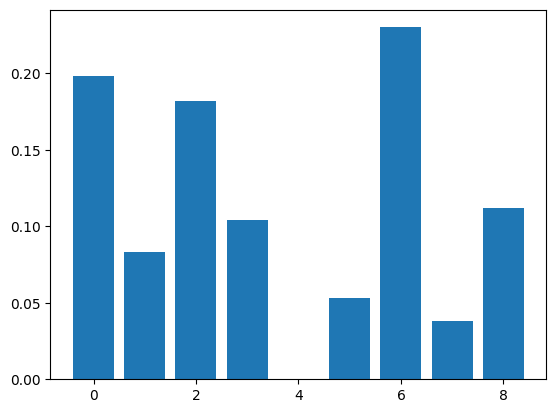

player 'x' to play...

	.  .  .
	.  x  .
	o  .  .

valid moves: [0 1 2 3 5 7 8]
player 'o' to play...

	x  .  .
	.  x  .
	o  .  .

valid moves: [1 2 3 5 7 8]


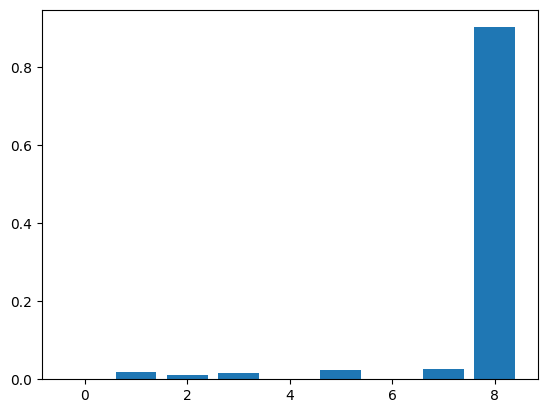

player 'x' to play...

	x  .  .
	.  x  .
	o  .  o

valid moves: [1 2 3 5 7]
player 'o' to play...

	x  .  .
	.  x  .
	o  x  o

valid moves: [1 2 3 5]


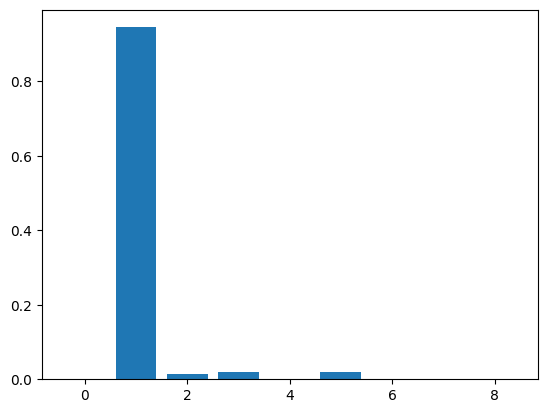

player 'x' to play...

	x  o  .
	.  x  .
	o  x  o

valid moves: [2 3 5]
player 'o' to play...

	x  o  .
	.  x  x
	o  x  o

valid moves: [2 3]


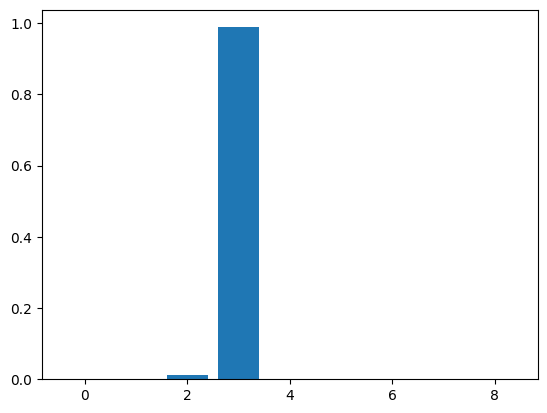

player 'x' to play...

	x  o  .
	o  x  x
	o  x  o

valid moves: [2]
player 'o' to play...

	x  o  x
	o  x  x
	o  x  o

valid moves: []
draw!


In [482]:
t3 = TicTacToe()
state = t3.init_state()
player = t3.first_player

mcts = MCTS(t3, params)

while True:
    print(f"player '{players[player]}' to play...")
    print_state(state)

    available_actions = t3.available_actions(state)
    print(f"valid moves: {available_actions}")
    
    if len(available_actions) == 0:
        print("draw!")
        break        

    if player == t3.first_player:
        action = input(f"provide a valid move: ")
        action = int(action)
    else:
        # mcts sees the state from the perspective of player 1.
        # If it's player -1, we change the perspective.
        neutral_state = t3.neutral_perspective(state, player)
        policy = mcts.best_policy(neutral_state, action)
        plt.bar(range(len(policy)), policy)
        plt.show()
        action = np.argmax(policy)

    state = t3.next_state(state, action, player)

    if t3.won(state, action):
        print_state(state)
        print(f"player {players[player]} won!")
        break
    
    player = t3.opponent(player)


### Machine-Machine Play

player 'x' to play...

	.  .  .
	.  .  .
	.  .  .

available actions: [0 1 2 3 4 5 6 7 8]


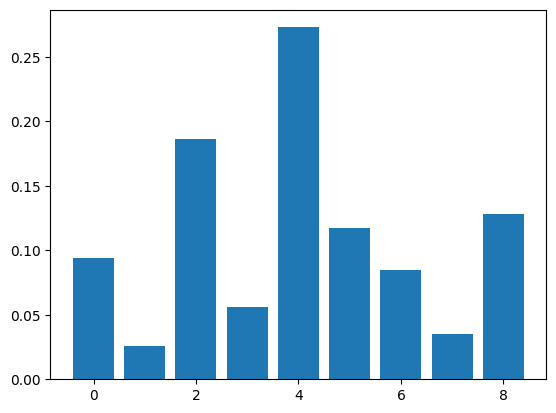

player 'o' to play...

	.  .  .
	.  x  .
	.  .  .

available actions: [0 1 2 3 5 6 7 8]


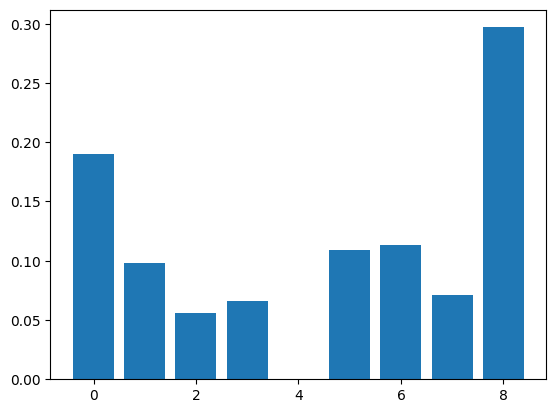

player 'x' to play...

	.  .  .
	.  x  .
	.  .  o

available actions: [0 1 2 3 5 6 7]


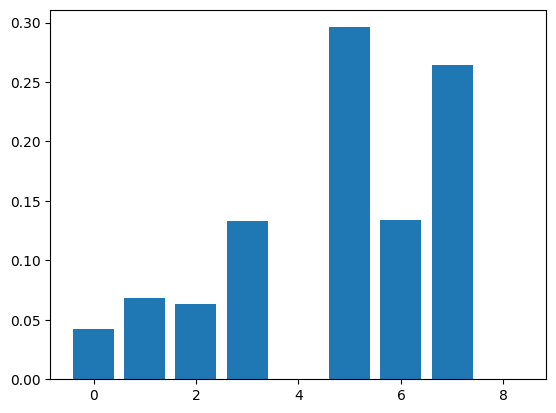

player 'o' to play...

	.  .  .
	.  x  x
	.  .  o

available actions: [0 1 2 3 6 7]


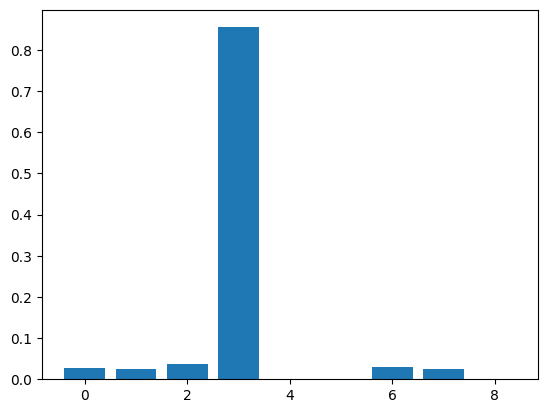

player 'x' to play...

	.  .  .
	o  x  x
	.  .  o

available actions: [0 1 2 6 7]


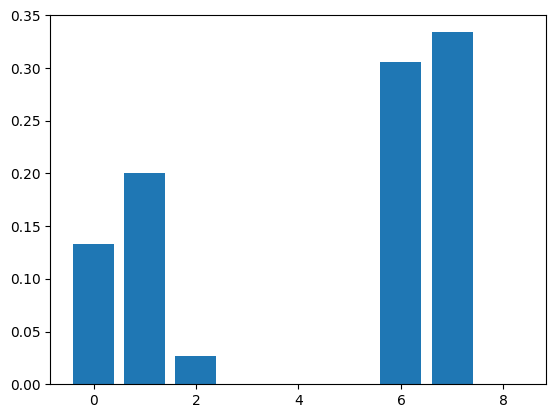

player 'o' to play...

	.  .  .
	o  x  x
	.  x  o

available actions: [0 1 2 6]


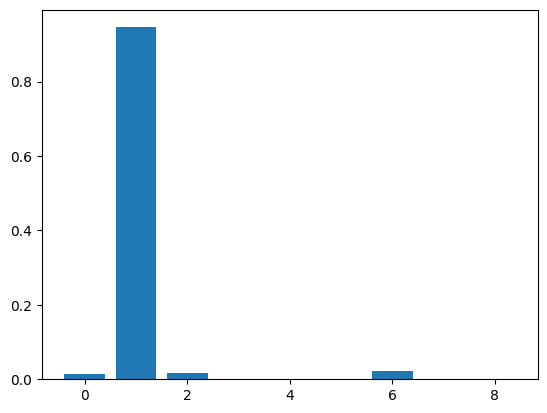

player 'x' to play...

	.  o  .
	o  x  x
	.  x  o

available actions: [0 2 6]


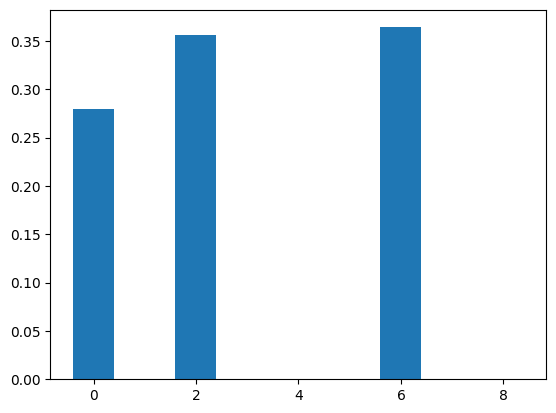

player 'o' to play...

	.  o  .
	o  x  x
	x  x  o

available actions: [0 2]


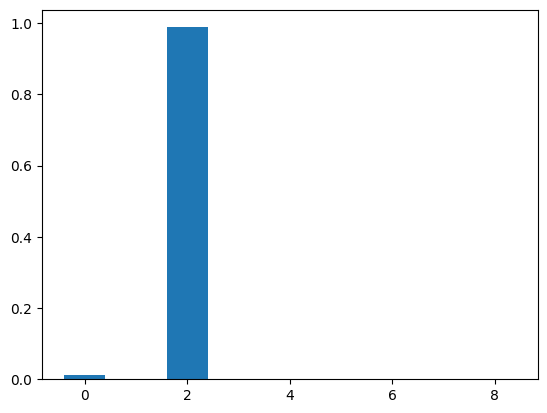

player 'x' to play...

	.  o  o
	o  x  x
	x  x  o

available actions: [0]


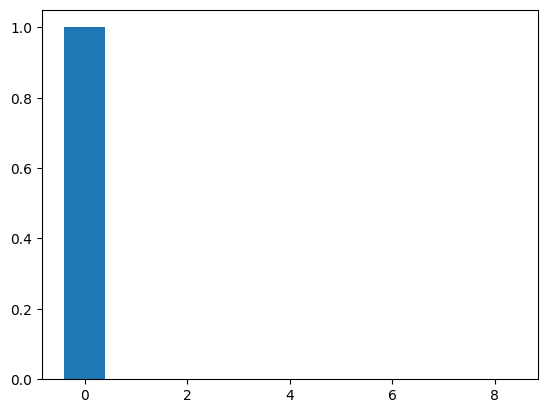

player 'o' to play...

	x  o  o
	o  x  x
	x  x  o

available actions: []
draw!


In [483]:
t3 = TicTacToe()
state = t3.init_state()
player = t3.first_player
action = None

mcts = MCTS(t3, params)

while True:
    print(f"player '{players[player]}' to play...")
    print_state(state)

    available_actions = t3.available_actions(state)
    print(f"available actions: {available_actions}")
    
    if len(available_actions) == 0:
        print("draw!")
        break        
    
    neutral_state = t3.neutral_perspective(state, player)
    policy = mcts.best_policy(neutral_state, action)
    plt.bar(range(len(policy)), policy)
    plt.show()
    action = np.argmax(policy)

    state = t3.next_state(state, action, player)

    if t3.won(state, action):
        print_state(state)
        print(f"player {players[player]} won!")
        break
    
    player = t3.opponent(player)

# MCTS with Neural Networks

We modify the tree search by replacing the simulation step with a neural network which returns a policy and a reward for a given state. The serarch tree is created as follows. We first create a root node with a given state. Then, we follow these steps:

1. As long as the node has children, compute the Upper Confidence Bound (UCB) for each of its children and select the one with the highest UCB. Repeat this until you reach a leaf node.
2. Given the current node state, run a convolutional neural network (CNN) to get the policy and reward.
3. Fully expand this leaf node using the policy.
4. Using the reward, run the backpropagation to update the reward_sum and visit_count on all the nodes in the path from the node to the root.

This process is repeated for a set number of iteration. After that we look at the immediate children of the root node and compute the probability distribution of the visit_counts. We use this distribution to determine the next move.

<center>
<img src="./images/mcts-cnn-algorithm.png" width="500">
</center>

We use the following formula to compute the UCB of children nodes from a parent node to find out which child to select in the selection step.

$$
\frac{v_c}{n_c}+cp_c\frac{\sqrt{n_p}}{1 + n_c},
$$

where 

* $n_p$ is the visit count of the parent node $P$,
* $n_c$ is the visit count of the child node $C$,
* $v_c$ is the total reward (number of wins minus number of losses),
* $p_c$ is the prior probability provided by the policy from the CNN model for the child node state, 
* $c$ is the exploration factor.

## CNN Model

The neural network learns the following function which maps a state $S$ to a policy-reward pair $(P, R)$:

$$
f(S) = (P, R).
$$

The policy $P$ is a probability distribution of all possible next states from $S$ and $v$ is reward in $(-1, 1)$ which is interpreted as reward. Rewards close to $1$ indicates winning, while rewards close to $-1$ indicates losing. The rewards close to $0$ is interpreted as a drawish situation.

We use convolutional neural networks (CNN) and interpret a state as an image. We use one-hot encoding for possible rewards $\{-1, 0, 1\}$ of each cell in a given state. So, let's define:

* $-1$: $[1, 0 ,0]$
* $\phantom{-}0$: $[0, 1 ,0]$
* $\phantom{-}1$: $[0, 0 ,1]$

As a result, we have a 3D input of size $3\times 3\times 3$ for a given state.

Then, we build multiple convolutional layers followed by two head as follows:

* **Policy Head:** The output layer size in this head is the number of possible next states. We apply softmax on the output layer to obtain a probability distribution which can be used to decide the next move.
* **Reward Head:** the output layer size in this head is one. We apply `Tanh` activation function to get a reward in $(-1, 1)$ representing a reward for the input state $S$. The reward is the model evaluation of a given state.

<center>
<img src="./images/tictactoe-cnn-model.png" width=600>
</center>

As we can see, we encode the current state and feed into the ResNet model which consists of multiple blocks arranged sequentially. A single block of the ResNet model consists of convolutional and batch normalization layers and ReLU activations as follows. Note that a skip connection is also added to the block.

<center>
<img src="./images/resnet-block.png" width=200>
</center>

In [419]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [467]:
params = {
    "exploratin_factor": 2,
    "num_iters": 1000,
    "kernel_size": 3,
    "padding": 1,
    "embd_size": 3,
    "hidden_size": 64,
    "num_blocks": 4,
    "num_epochs": 1000,
    "batch_size": 64,
    "num_self_plays": 500,
    "load_data": True,
    "load_model": True,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")    
}

In [453]:
class ResBlock(nn.Module):
    def __init__(self, hidden_size, params):
        super().__init__()
        kernel_size = params["kernel_size"]
        padding = params["padding"]

        self. res_block = nn.Sequential(
            nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(hidden_size)
        )
        
    def forward(self, x):
        out = x + self.res_block(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, board_size, embd_size, hidden_size, num_blocks, params):
        super().__init__()
        kernel_size = params["kernel_size"]
        padding = params["padding"]

        self.start_block = nn.Sequential(
            nn.Conv2d(embd_size, hidden_size, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU()
        )
        
        self.res_blocks = nn.ModuleList(
            [ResBlock(hidden_size, params) for _ in range(num_blocks)]
        )
        
        self.policy_head = nn.Sequential(
            nn.Conv2d(hidden_size, embd_size, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(embd_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(embd_size * board_size**2, board_size**2)
        )
        
        self.reward_head = nn.Sequential(
            nn.Conv2d(hidden_size, embd_size, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(embd_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(embd_size * board_size**2, 1),
            nn.Tanh()            
        )
        
    def forward(self, x):
        '''
        Input x is a 4D tensor of size (batch_size, embd_size, height, width).
        '''
        out = self.start_block(x)
        
        for res_block in self.res_blocks:
            out = res_block(out)
            
        policy_logit = self.policy_head(out)
        reward = self.reward_head(out)
        
        return policy_logit, reward

In [454]:
def encode_state(state):
    # m, n = state.shape
    # the output shape is 3 x m x n
    return np.stack(
        [state == 1, state == 0, state == -1]
    ).astype(np.float32)

def decode_state(state):
    # 1 * state[0] + 0 * state[1] + (-1) * state[2]
    return state[0]-state[2]
    
def get_policy(logit, state):
    # B, C = logit.shape, where B is the batch size and C is 
    # the number of classes (states).
    # mark illegal moves as -inf so they vanish after softmax
    logit[:, state.reshape(-1) != 0] = float("-inf")
    policy = F.softmax(logit, dim=1)
    return policy

In [456]:
class TicTacToe(object):
    def __init__(self):
        self.board_size = 3
        self.first_player = 1

    def init_state(self):
        return np.zeros((self.board_size, self.board_size), dtype=np.int8)

    def next_state(self, state, action, player):
        row, col = self.coord(action)
        state[row, col] = player
        return state

    def coord(self, action):
        return action//self.board_size, action%self.board_size
    
    def won(self, state, action):
        if action is None:
            return False
        row, col = self.coord(action)
        player = state[row, col]

        win_sum = player * self.board_size
        row_win = np.sum(state[row, :]) == win_sum
        col_win = np.sum(state[:, col]) == win_sum
        diag_win = np.sum(np.diag(state)) == win_sum
        offdiag_win = np.sum(np.diag(np.fliplr(state))) == win_sum
    
        return row_win or col_win or diag_win or offdiag_win
    
    def opponent(self, player):
        return -player

    def opponent_reward(self, reward):
        return -reward
    
    def neutral_perspective(self, state, player):
        '''
        Perspective of the first (default) player.
        For player 1, the state is unchaged while player -1's perspective
        of the state is reversed so as if player 1 sees the state.
        '''
        return player * state 
    
    def available_actions(self, state):
        return np.where(state.reshape(-1) == 0)[0]

    def is_over(self, state, action):
        '''
        The game is over when the player wins or there is no mover left.
        '''
        return self.won(state, action) or (np.sum(state == 0) == 0)

    def reward(self, won):
        return 1 if won else 0


class Node(object):
    def __init__(self, game, state, params, parent=None, parent_action=None, prior_prob=0):
        '''
        `parent` took `parent_action` which resulted in the current `state`.
        The `parent_action` had `prior_prob` among all possible actions.
        '''
        self.game = game
        self.state = state
        self.params = params
        self.parent = parent
        self.parent_action = parent_action
        self.prior_prob = prior_prob

        self.children = []

        # reward reward for the current state which can be positive or negative.
        self.reward_sum = 0
        # number of visits at this node.
        self.visit_count = 0

    def is_fully_expanded(self):
        return len(self.children) > 0

    def expected_reward(self, child):
        if child.visit_count == 0:
            return 0
        return -child.reward_sum / child.visit_count

    def ucb(self, child):
        '''
        Computes the Upper Confidence Bound (UCB).
        '''
        exploratin_factor = self.params["exploratin_factor"]
        exploration = np.sqrt(self.visit_count) / (1 + child.visit_count)
        return self.expected_reward(child) + exploratin_factor*child.prior_prob*exploration

    def select(self):
        k = np.argmax([self.ucb(child) for child in self.children])
        return self.children[k]

    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob == 0:
                continue
            player = self.game.first_player
            other_player = self.game.opponent(player)
            # we assume this player is always the player 1, without loss of generality.
            child_state = self.game.next_state(self.state.copy(), action, player=player)
            child_state = self.game.neutral_perspective(child_state, other_player)
            child_node = Node(self.game, child_state, self.params, self, action, prob)
            self.children.append(child_node)

    def backward(self, reward):
        '''
        Backpropagate reward and visit counts from the node to the root.
        '''
        self.reward_sum += reward
        self.visit_count += 1
        # parent node is the opponent of the child node.
        reward = self.game.opponent_reward(reward)
        if self.parent is not None:
            self.parent.backward(reward)


class MCTS(object):
    '''
    Monte Carlo Tree Search (MCTS) implementation with neural networks. It replaces
    the simulation step with a convolutional neural network (CNN) which gets a state
    and return a policy and a reward.
    
    It has no notion of players. It sees the state from the perspective of alternating
    players in each iteration. This is useful when two machines play as we can just
    change the perspective.
    '''
    def __init__(self, game, model, params):
        self.game = game
        self.params = params
        self.model = model
    
    @torch.no_grad()    
    def best_policy(self, state):
        num_iters = self.params["num_iters"]
        root = Node(self.game, state, self.params)
  
        for _ in range(num_iters):
            # starting from the root, select a child with highest UCB if it's fully expanded, 
            # or expand it.
            node = root
            while node.is_fully_expanded():
                node = node.select()

            if not self.game.is_over(node.state, node.parent_action):
                enc_state = encode_state(node.state)
                enc_state = torch.tensor(enc_state).unsqueeze(0).to(self.params["device"])

                logit, reward = self.model(enc_state)

                reward = reward.item()
                policy = get_policy(logit, node.state)  
                policy = policy.squeeze(0).detach().cpu().numpy()              

                node.expand(policy)
            else:
                won = self.game.won(node.state, node.parent_action)
                reward = self.game.reward(won)
                reward = self.game.opponent_reward(reward)

            node.backward(reward)
            
        return self.compute_policy(root)

    def compute_policy(self, root):
        '''
        Returns the probability distribution of the visit counts.
        '''
        out = np.zeros(self.game.board_size**2)
        for child in root.children:
            out[child.parent_action] = child.visit_count
        out /= np.sum(out)
        return out        
        

## Self-Play and Training Dataset

We now devise an algorithm to generate training dataset for the CNN model. As we demonstrated before, the machine can play against itself (self-play) starting from random moves. We collect the following data from self-plays as our training dataset. In particular, we collect the following features frm the final state of each self-play:

* State
* Policy
* Reward

The training dataset will be used to train a CNN model that optimizes loss functions for policy and reward.

In [457]:
def generate_data(mcts):
    t3 = mcts.game    
    player = t3.first_player
    state, reward = t3.init_state(), 0
    states, policies, players = [], [], []

    while True:
        available_actions = t3.available_actions(state)
        if len(available_actions) == 0:
            break        
        
        players.append(player)

        neutral_state = t3.neutral_perspective(state, player)
        states.append(encode_state(neutral_state))

        policy = mcts.best_policy(neutral_state)
        policies.append(policy)
        
        action = np.random.choice(len(policy), p=policy)
        # action = np.argmax(policy)
        state = t3.next_state(state, action, player)

        if t3.won(state, action):
            # Get default winning value as reward
            reward = t3.reward(True)
            break
        
        player = t3.opponent(player)

    rewards = [reward if p == player else t3.opponent_reward(reward) for p in players]
    return states, policies, rewards

    # rewards = np.full(len(states), reward)
    # if reward != 0:
    #     # rewards list should be alternating 1, -1 ending to 1 
    #     rewards[len(states)%2::2] = t3.opponent_reward(reward)
    # return states, policies, rewards.tolist()


def generate_dataset(mcts, num_self_plays):
    states, policies, rewards = [], [], []

    for _ in trange(num_self_plays):
        s, p, r = generate_data(mcts)
        states.extend(s)
        policies.extend(p)
        rewards.extend(r)

    return np.array(states), np.array(policies), np.array(rewards)

## Untrained Model Result

As we can see in the following, the untrained model prediction is random and the policy is almost uniformly distributed for a winning state. We will train the model and do the same examination to test how the model learned.

state:

	.  .  o
	.  o  .
	x  .  x

reward: 0.1590816229581833
policy bar plot:


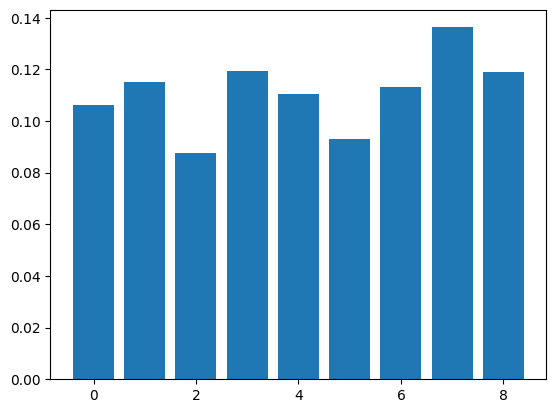

In [432]:
t3 = TicTacToe()

model = ResNet(
    t3.board_size, 
    embd_size=params["embd_size"], 
    hidden_size=params["hidden_size"], 
    num_blocks=params["num_blocks"],
    params=params).to(device=params["device"])

model.eval()

state = t3.init_state()
state = t3.next_state(state, 6, 1)
state = t3.next_state(state, 4, -1)
state = t3.next_state(state, 8, 1)
state = t3.next_state(state, 2, -1)

enc_state = encode_state(state)
enc_state = torch.tensor(enc_state, dtype=torch.float32).unsqueeze(0)

policy, reward = model(enc_state)
policy = F.softmax(policy, dim=1).squeeze(0).detach().cpu().numpy()

print("state:")
print_state(state)
print(f"reward: {reward.item()}")
print("policy bar plot:")
plt.bar(range(len(policy)), policy)
plt.show()

In the following, we run the MCTS algorithm on an untrained model. This is equvalent of the simulation we previously performed. As we can see, the machine plays well.

We will train a model and test it without the simulation to see how it performs.

state:

	.  .  .
	.  .  .
	.  .  .

reward: 0
policy bar plot:


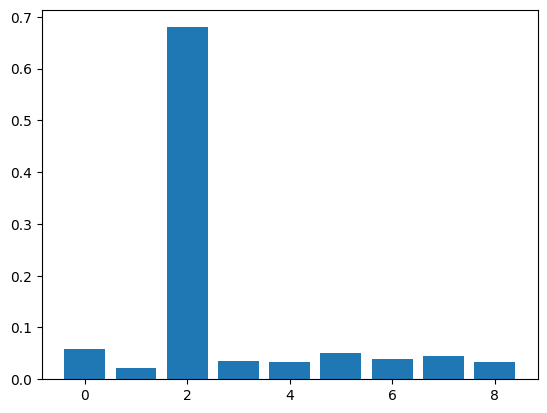

state:

	.  .  o
	.  .  .
	.  .  .

reward: 0
policy bar plot:


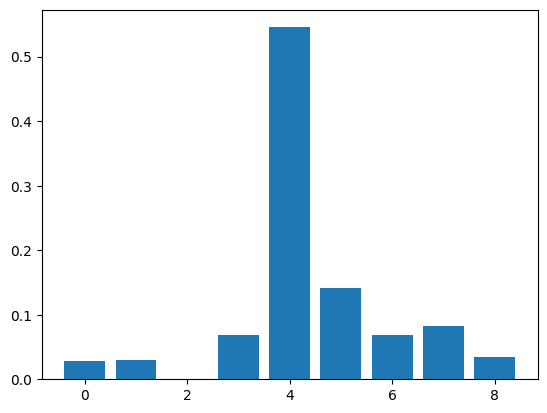

state:

	.  .  x
	.  o  .
	.  .  .

reward: 0
policy bar plot:


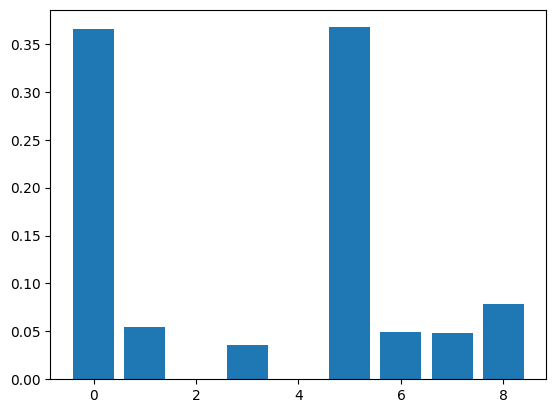

state:

	.  .  o
	.  x  o
	.  .  .

reward: 0
policy bar plot:


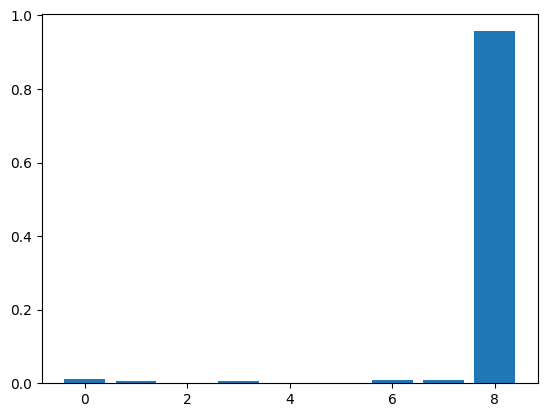

state:

	.  .  x
	.  o  x
	.  .  o

reward: 0
policy bar plot:


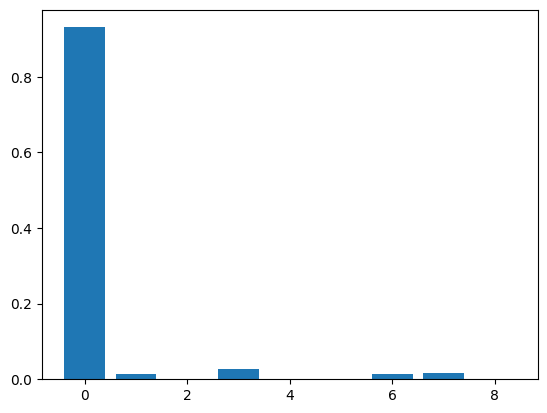

state:

	o  .  o
	.  x  o
	.  .  x

reward: 0
policy bar plot:


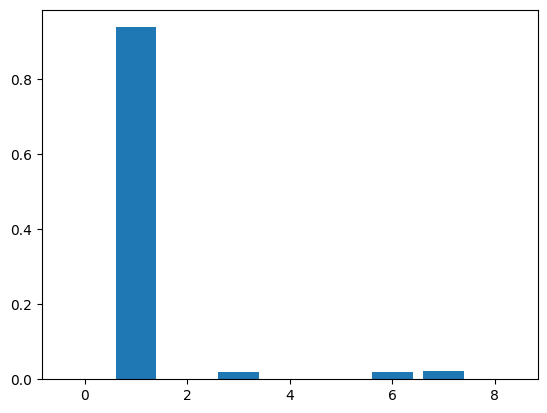

state:

	x  o  x
	.  o  x
	.  .  o

reward: 0
policy bar plot:


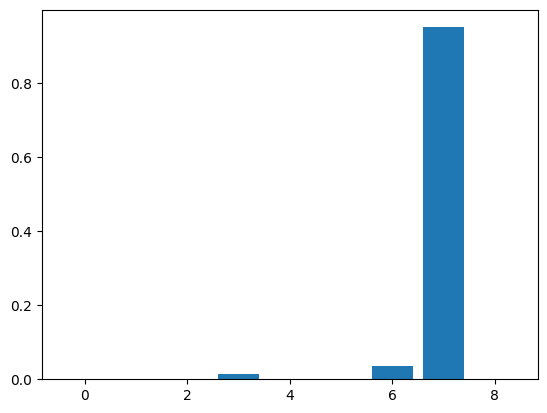

state:

	o  x  o
	.  x  o
	.  o  x

reward: 0
policy bar plot:


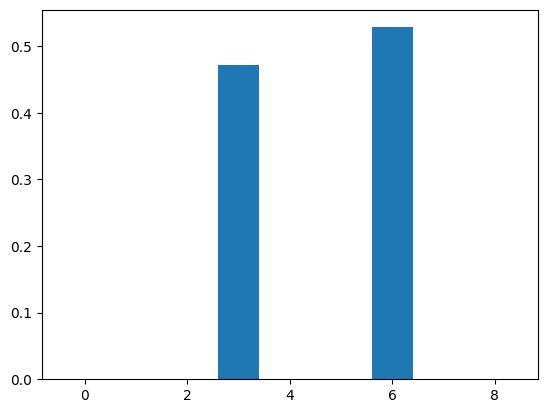

state:

	x  o  x
	.  o  x
	o  x  o

reward: 0
policy bar plot:


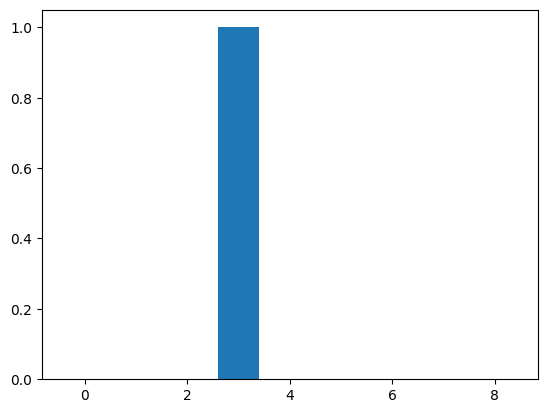

In [433]:
t3 = TicTacToe()

model = ResNet(
    t3.board_size, 
    embd_size=params["embd_size"], 
    hidden_size=params["hidden_size"], 
    num_blocks=params["num_blocks"],
    params=params).to(device=params["device"])

if params["load_model"]:
    check_point = torch.load(f"./models/model_{params["num_epochs"]}.pt")
    model.load_state_dict(check_point["model"])
    model.eval()

mcts = MCTS(t3, model, params)

states, policies, rewards = generate_data(mcts)

for state, policy, reward in zip(states, policies, rewards):
    print("state:")
    print_state(decode_state(state))
    print(f"reward: {reward}")
    print("policy bar plot:")
    plt.bar(range(len(policy)), policy)
    plt.show()

## CNN Model Training

In [458]:
class Loss(object):
    def __init__(self):
        self.train = []
        self.eval = []

class Losses(object):
    def __init__(self):
        self.policy = Loss()
        self.reward = Loss()

@torch.no_grad()
def evaluate_model(model, data, losses):
    model.eval()

    states, policies, rewards = data
    target_states = torch.tensor(states, dtype=torch.float32)
    target_policies = torch.tensor(policies, dtype=torch.float32)
    target_rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)

    pred_policies, pred_rewards = model(target_states)  
    pred_policies = F.softmax(pred_policies, dim=1)

    policy_loss = F.cross_entropy(pred_policies, target_policies)
    reward_loss = F.mse_loss(pred_rewards, target_rewards)
    
    losses.policy.eval.append(policy_loss.item())
    losses.reward.eval.append(reward_loss.item())

def train_model(model, optimizer, train_data, eval_data, params, losses=None, num_models_to_save=1):
    num_epochs = params["num_epochs"]
    device = params["device"]
    batch_size = params["batch_size"]
    
    if losses is None:
        losses = Losses()

    states, policies, rewards = train_data

    for epoch in trange(num_epochs):
        model.train()
        batch_indices = np.random.choice(len(states), batch_size)

        target_states = torch.tensor(states[batch_indices], dtype=torch.float32, device=device)
        target_policies = torch.tensor(policies[batch_indices], dtype=torch.float32, device=device)
        target_rewards = torch.tensor(rewards[batch_indices], dtype=torch.float32, device=device).unsqueeze(1)

        pred_policies, pred_rewards = model(target_states)
        pred_policies = F.softmax(pred_policies, dim=1)

        policy_loss = F.cross_entropy(pred_policies, target_policies)
        reward_loss = F.mse_loss(pred_rewards, target_rewards)
        
        optimizer.zero_grad(set_to_none=True)
        policy_loss.backward(retain_graph=True)
        reward_loss.backward()
        optimizer.step()

        losses.policy.train.append(policy_loss.item())
        losses.reward.train.append(reward_loss.item())
        
        if (epoch+1) % int(num_epochs / num_models_to_save) == 0:
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            torch.save(checkpoint, f"./models/model_{epoch+1}.pt")
            
        model.eval()
        evaluate_model(model, eval_data, losses)

    return losses   

In [459]:
t3 = TicTacToe()

model = ResNet(
    t3.board_size, 
    embd_size=params["embd_size"], 
    hidden_size=params["hidden_size"], 
    num_blocks=params["num_blocks"],
    params=params).to(device=params["device"])

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [460]:
model.eval()
mcts = MCTS(t3, model, params)
load_data = params["load_data"]

if load_data:
    data_checkpoint = torch.load("./data/data.pt")
    train_data = data_checkpoint["train_data"]
    eval_data = data_checkpoint["eval_data"]
else:
    num_self_plays = params["num_self_plays"]
    train_data = generate_dataset(mcts, num_self_plays)
    eval_data = generate_dataset(mcts, int(0.1 * num_self_plays))

    data_checkpoint = {
        "train_data": train_data,
        "eval_data": eval_data,
    }
    torch.save(data_checkpoint, "./data/data.pt")

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [461]:
losses = None

In [466]:
load_model = params["load_model"]
num_models_to_save = 10

if load_model:
    check_point = torch.load(f"./models/model_{params["num_epochs"]}.pt")
    model.load_state_dict(check_point["model"])
    optimizer.load_state_dict(check_point["optimizer"])
else:
    losses = train_model(model, optimizer, train_data, eval_data, params, 
                         losses=losses, 
                         num_models_to_save=num_models_to_save)

  0%|          | 0/1000 [00:00<?, ?it/s]

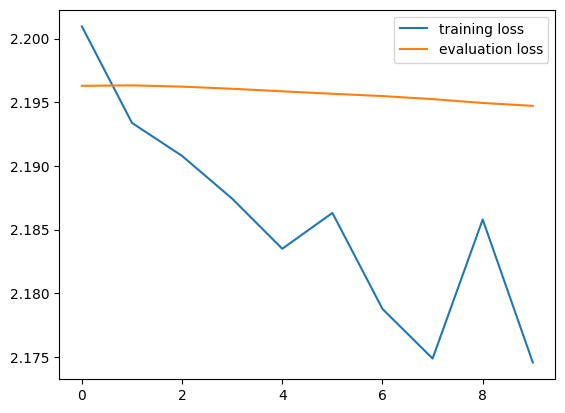

In [463]:
plt.plot(losses.policy.train)
plt.plot(losses.policy.eval)
plt.legend(["training loss", "evaluation loss"])
plt.show()

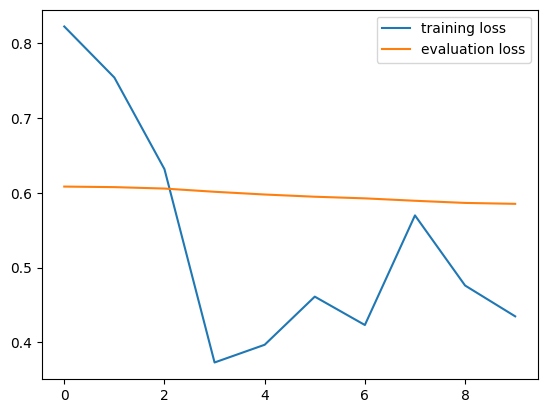

In [464]:
plt.plot(losses.reward.train)
plt.plot(losses.reward.eval)
plt.legend(["training loss", "evaluation loss"])
plt.show()

## Trained Model

Recall that we tested an untrained model on a winning state and got uniform distribution for the policy. Now, we have a trained model and can test it on the same state.

As we can see in the following, we get predicted reward as 0.9 and action 8 with the highest probability, which is a winning move.

state:

	.  .  o
	.  o  .
	x  .  x

reward: 0.9060020446777344
policy bar plot:


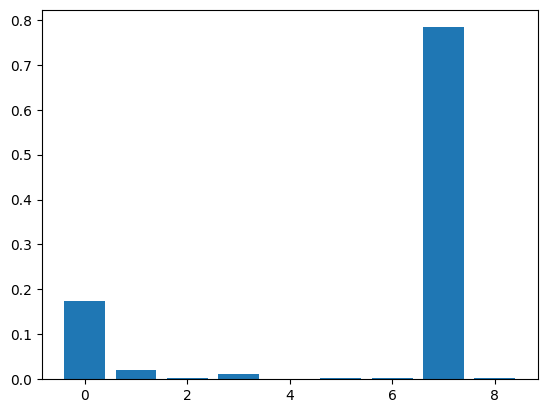

In [468]:
t3 = TicTacToe()

model = ResNet(
    t3.board_size, 
    embd_size=params["embd_size"], 
    hidden_size=params["hidden_size"], 
    num_blocks=params["num_blocks"],
    params=params).to(device=params["device"])

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

check_point = torch.load(f"./models/model_{params["num_epochs"]}.pt")
model.load_state_dict(check_point["model"])
optimizer.load_state_dict(check_point["optimizer"])

model.eval()

state = t3.init_state()
state = t3.next_state(state, 6, 1)
state = t3.next_state(state, 4, -1)
state = t3.next_state(state, 8, 1)
state = t3.next_state(state, 2, -1)

enc_state = encode_state(state)
enc_state = torch.tensor(enc_state, dtype=torch.float32).unsqueeze(0)

policy, reward = model(enc_state)
policy = F.softmax(policy, dim=1).squeeze(0).detach().cpu().numpy()

print("state:")
print_state(state)
print(f"reward: {reward.item()}")
print("policy bar plot:")
plt.bar(range(len(policy)), policy)
plt.show()

## Human-Machine Play 

player 'x' to play...

	.  .  .
	.  .  .
	.  .  .

player 'o' to play...

	.  .  .
	.  x  .
	.  .  .

available actions: [0 1 2 3 5 6 7 8]


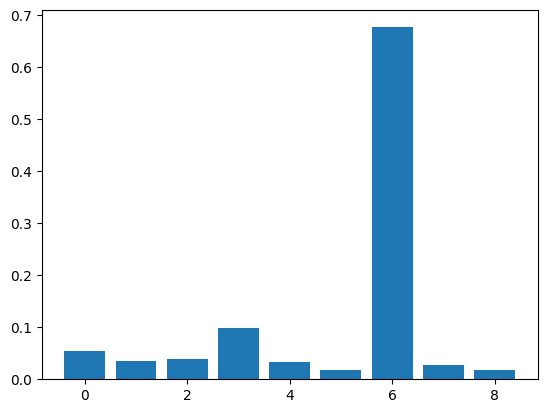

player 'x' to play...

	.  .  .
	.  x  .
	o  .  .

player 'o' to play...

	x  .  .
	.  x  .
	o  .  .

available actions: [1 2 3 5 7 8]


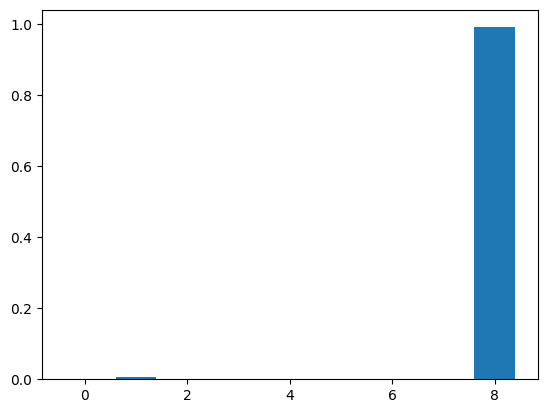

player 'x' to play...

	x  .  .
	.  x  .
	o  .  o

player 'o' to play...

	x  .  .
	.  x  .
	o  x  o

available actions: [1 2 3 5]


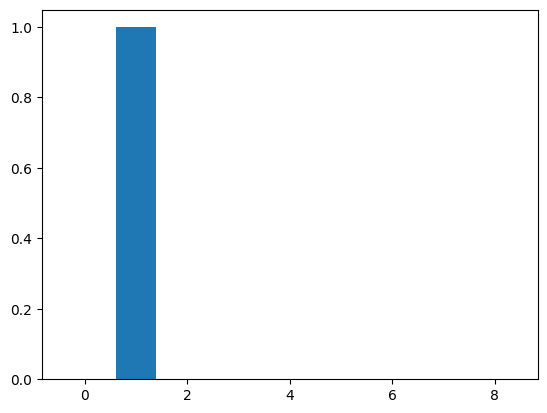

player 'x' to play...

	x  o  .
	.  x  .
	o  x  o

player 'o' to play...

	x  o  .
	.  x  x
	o  x  o

available actions: [2 3]


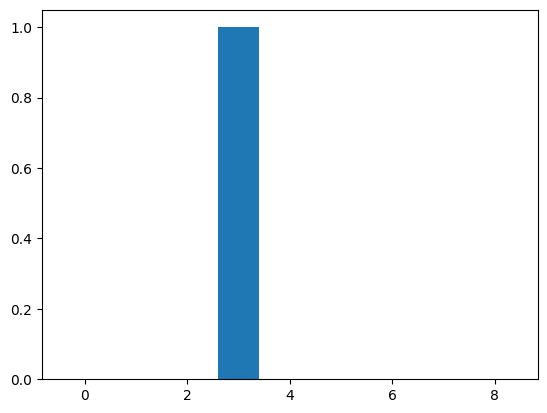

player 'x' to play...

	x  o  .
	o  x  x
	o  x  o

player 'o' to play...

	x  o  x
	o  x  x
	o  x  o

available actions: []
draw!


In [471]:
t3 = TicTacToe()
state = t3.init_state()
player = t3.first_player
reward = 0

model = ResNet(
    t3.board_size, 
    embd_size=params["embd_size"], 
    hidden_size=params["hidden_size"], 
    num_blocks=params["num_blocks"],
    params=params).to(device=params["device"])

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

check_point = torch.load(f"./models/model_{params["num_epochs"]}.pt")
model.load_state_dict(check_point["model"])
optimizer.load_state_dict(check_point["optimizer"])

model.eval()

while True:
    print(f"player '{players[player]}' to play...")
    print_state(state)

    if player == t3.first_player:
        action = int(input("enter your action:"))
    else:
        available_actions = t3.available_actions(state)
        print(f"available actions: {available_actions}")
        
        if len(available_actions) == 0:
            print("draw!")
            break        
        
        neutral_state = t3.neutral_perspective(state, player)
        enc_state = encode_state(neutral_state)
        enc_state = torch.tensor(enc_state, dtype=torch.float32).unsqueeze(0)
        logit, reward = model(enc_state)
        
        policy = F.softmax(logit, dim=1).squeeze(0).detach().cpu().numpy()

        plt.bar(range(len(policy)), policy)
        plt.show()

        action = np.argmax(policy)

    state = t3.next_state(state, action, player)

    if t3.won(state, action):
        print_state(state)
        print(f"player {players[player]} won!")
        break
    
    player = t3.opponent(player)


## Machine-Machine Play

player 'x' to play...

	.  .  .
	.  .  .
	.  .  .

available actions: [0 1 2 3 4 5 6 7 8]


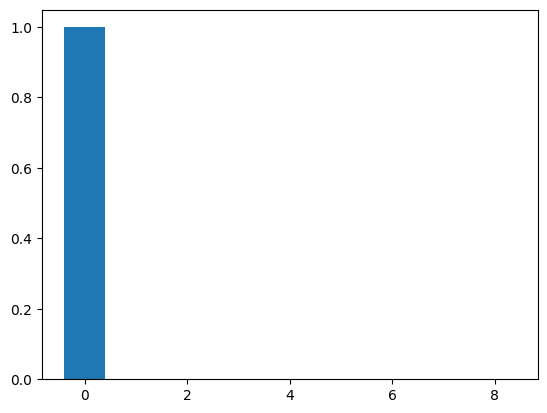

player 'o' to play...

	x  .  .
	.  .  .
	.  .  .

available actions: [1 2 3 4 5 6 7 8]


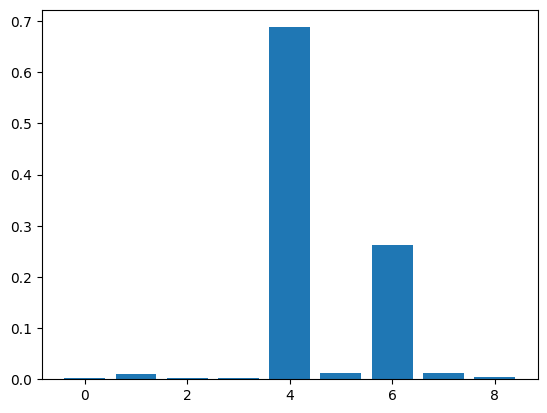

player 'x' to play...

	x  .  .
	.  o  .
	.  .  .

available actions: [1 2 3 5 6 7 8]


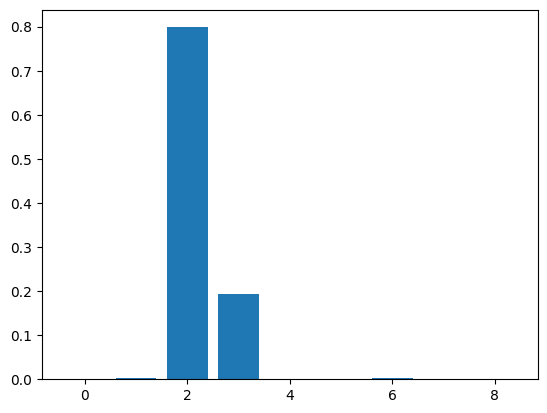

player 'o' to play...

	x  .  x
	.  o  .
	.  .  .

available actions: [1 3 5 6 7 8]


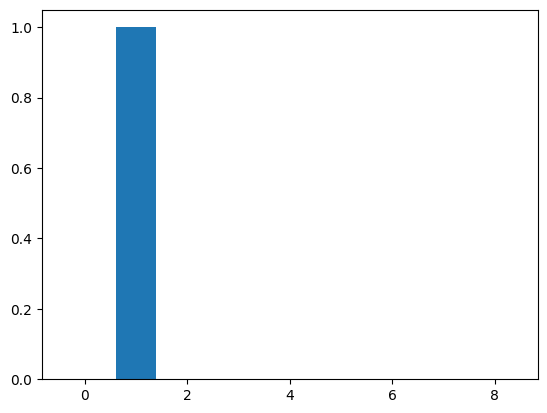

player 'x' to play...

	x  o  x
	.  o  .
	.  .  .

available actions: [3 5 6 7 8]


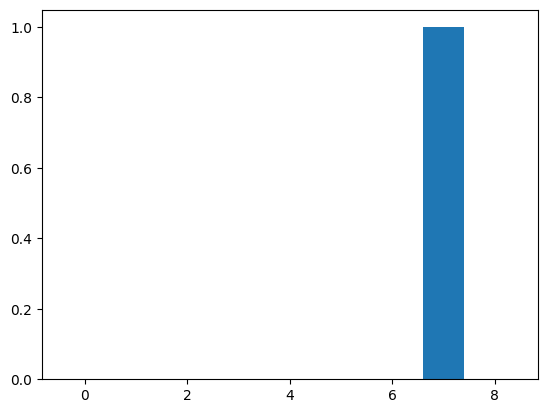

player 'o' to play...

	x  o  x
	.  o  .
	.  x  .

available actions: [3 5 6 8]


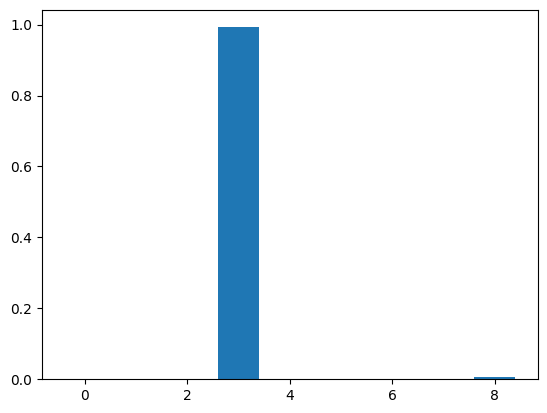

player 'x' to play...

	x  o  x
	o  o  .
	.  x  .

available actions: [5 6 8]


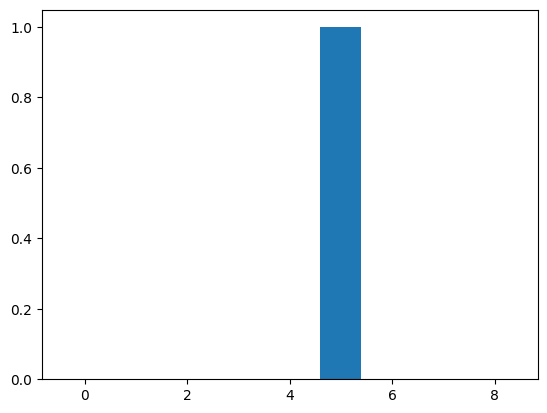

player 'o' to play...

	x  o  x
	o  o  x
	.  x  .

available actions: [6 8]


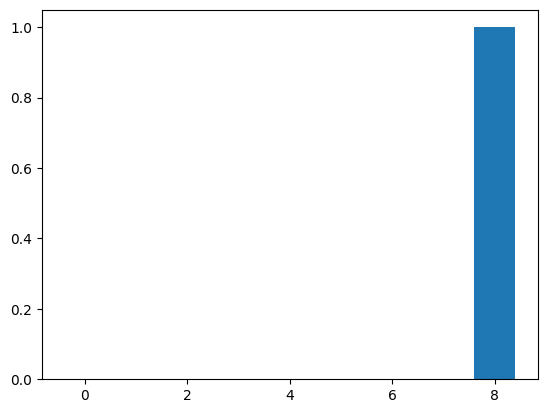

player 'x' to play...

	x  o  x
	o  o  x
	.  x  o

available actions: [6]


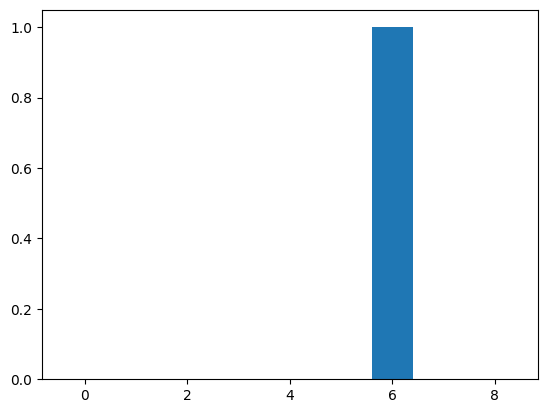

player 'o' to play...

	x  o  x
	o  o  x
	x  x  o

available actions: []
draw!


In [472]:
t3 = TicTacToe()
state = t3.init_state()
player = t3.first_player
reward = 0

model = ResNet(
    t3.board_size, 
    embd_size=params["embd_size"], 
    hidden_size=params["hidden_size"], 
    num_blocks=params["num_blocks"],
    params=params).to(device=params["device"])

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

check_point = torch.load(f"./models/model_{params["num_epochs"]}.pt")
model.load_state_dict(check_point["model"])
optimizer.load_state_dict(check_point["optimizer"])

model.eval()

while True:
    print(f"player '{players[player]}' to play...")
    print_state(state)

    available_actions = t3.available_actions(state)
    print(f"available actions: {available_actions}")
    
    if len(available_actions) == 0:
        print("draw!")
        break        
    
    neutral_state = t3.neutral_perspective(state, player)
    enc_state = encode_state(neutral_state)
    enc_state = torch.tensor(enc_state, dtype=torch.float32).unsqueeze(0)
    logit, reward = model(enc_state)
    
    policy = F.softmax(logit, dim=1).squeeze(0).detach().cpu().numpy()

    plt.bar(range(len(policy)), policy)
    plt.show()

    action = np.argmax(policy)

    state = t3.next_state(state, action, player)

    if t3.won(state, action):
        print_state(state)
        print(f"player {players[player]} won!")
        break
    
    player = t3.opponent(player)
